<a href="https://colab.research.google.com/github/hermathena/Sales-Orders-Analysis/blob/main/Sales_Orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install catboost
!pip install pingouin
!pip install shap
!pip install skimpy

In [16]:
# Data manipulation
#===========================================================================
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# Data visualization
#===========================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
from wordcloud import WordCloud

# Stats
#===========================================================================
from scipy import stats
import pingouin as pg
import statsmodels.api as sm
#import ppscore as pps

# Preprocessing
#===========================================================================
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifier Models
#===========================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Regression Models
#===========================================================================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Metrics
#===========================================================================
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Feature importance
#===========================================================================
import shap

# tqdm
#===========================================================================
from tqdm.auto import tqdm

# Warnings
#===========================================================================
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import files
uploaded = files.upload()

Saving sales_data.csv to sales_data.csv


In [5]:
data = pd.read_csv("sales_data.csv")

In [6]:
data.head()

,Order Date,Order ID,Product,Product_ean,catégorie,Purchase Address,Quantity Ordered,Price Each,Cost price,turnover,margin
0,2019-01-22 21:25:00,141234,iPhone,5.638009e+12,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000
1,2019-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750
2,2019-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900
3,2019-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965
4,2019-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950


In [7]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 185950 │ │ float64     │ 5     │                                                          │
│ │ Number of columns │ 11     │ │ string      │ 4     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_n ┃    ┃      ┃          ┃          ┃          ┃          ┃          ┃          ┃          ┃        ┃  │
│ ┃ ame      ┃ NA ┃ NA % ┃ mean     ┃ sd       ┃ p0       ┃ p25      ┃ p50      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ Order ID │  0 │    0 │   230000 │    52000 │   140000 │   190000 │   230000 │   280000 │   320000 │ ▇▇▇▇▇▇ │  │
│ │ Product_ │  0 │    0 │ 55000000 │ 26000000 │ 10000000 │ 33000000 │ 55000000 │ 78000000 │ 10000000 │ ▇▇▇▇▇▇ │  │
│ │ ean      │    │      │    00000 │    00000 │    00000 │    00000 │    00000 │    00000 │   000000 │        │  │
│ │ Quantity │  0 │    0 │      1.1 │     0.44 │        1 │        1 │        1 │        1 │        9 │   ▇    │  │
│ │ Ordered  │    │      │          │          │          │          │          │          │          │        │  │
│ │ Price    │  0 │    0 │      180 │      330 │        3 │       12 │       15 │      150 │     1700 │  ▇▁▁   │  │
│ │ Each     │    │      │          │          │          │          │          │          │          │        │  │
│ │ Cost     │  0 │    0 │       70 │      110 │      1.5 │        6 │      7.5 │       98 │      560 │  ▇▃▁   │  │
│ │ price    │    │      │          │          │          │          │          │          │          │        │  │
│ │ turnover │  0 │    0 │      190 │      330 │        3 │       12 │       15 │      150 │     3400 │   ▇▁   │  │
│ │ margin   │  0 │    0 │      120 │      230 │      1.5 │        6 │      7.5 │       52 │     2300 │   ▇▁   │  │
│ └──────────┴────┴──────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA     ┃ NA %      ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Order Date                       │      0 │         0 │                          2 │                371900 │  │
│ │ Product                          │      0 │         0 │                        2.7 │                510249 │  │
│ │ catégorie                        │      0 │         0 │                          1 │                185950 │  │
│ │ Purchase Address                 │      0 │         0 │                        6.7 │               1239789 │  │
│ └──────────────────────────────────┴────────┴─────────

No NAs

In [8]:
## Checking duplicate rows
print(f'There are {data.duplicated().sum()} duplicate rows')

There are 0 duplicate rows


In [9]:
## Set the names of the columns

data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(' ', '_')
data.columns

Index(['Order_Date', 'Order_ID', 'Product', 'Product_ean', 'catégorie',
       'Purchase_Address', 'Quantity_Ordered', 'Price_Each', 'Cost_price',
       'turnover', 'margin'],
      dtype='object')

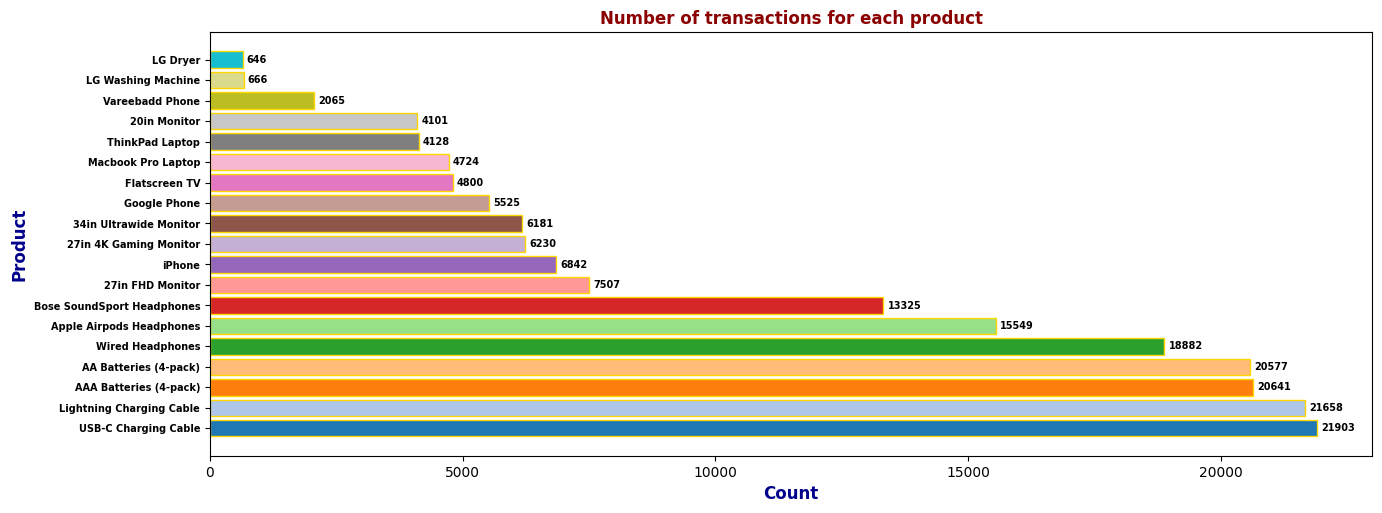

In [10]:
df_popu_prod = data['Product'].value_counts().to_frame()

labels = df_popu_prod.index.to_list()
values = df_popu_prod.iloc[:,0].values

cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (15,5.5))
rects = ax.barh(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.set_xlabel('Count', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Product', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_yticklabels(labels, fontsize = 7, fontweight = 'bold')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('Number of transactions for each product', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    width = rect.get_width()
    ax.annotate(text = '{}'.format(width),
                xy = (width, rect.get_y() + rect.get_height()/2),
                xytext = (3,0),
                textcoords = 'offset points',
                ha = 'left',
                va = 'center',
                weight = 'bold',
                size = 7,
                color = 'black')

autolabel(rects)
fig.show()

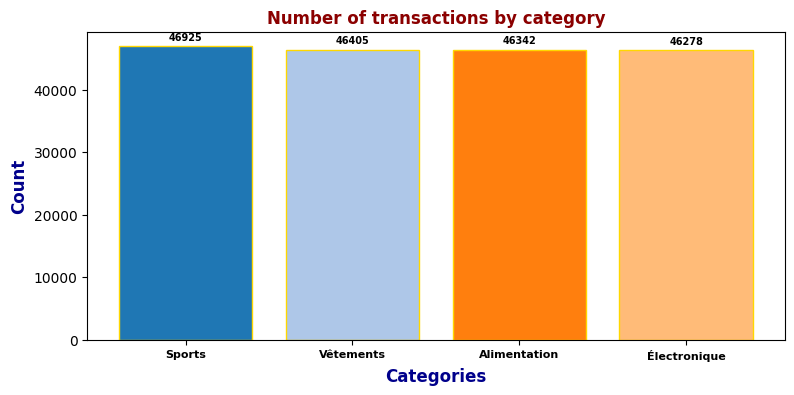

In [11]:
df_popu_categ = data['catégorie'].value_counts().to_frame()

labels = df_popu_categ.index.to_list()
values = df_popu_categ.iloc[:,0].values

cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (9,4))
rects = ax.bar(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.set_ylabel('Count', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Categories', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xticklabels(labels, fontsize = 8, fontweight = 'bold')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('Number of transactions by category', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = '{}'.format(height),
                xy = (rect.get_x() + rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                weight = 'bold',
                size = 7,
                color = 'black')

autolabel(rects)
fig.show()

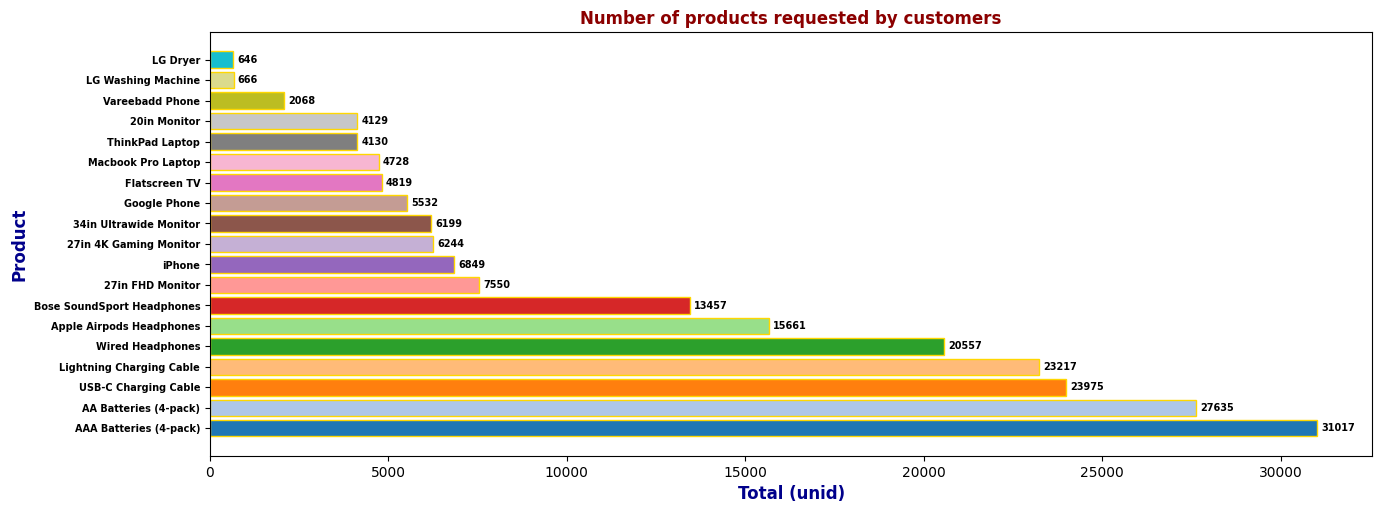

In [12]:
df_prod_quant = data.groupby('Product')['Quantity_Ordered'].sum().to_frame().sort_values('Quantity_Ordered', ascending = False)

labels = df_prod_quant.index.to_list()
values = df_prod_quant['Quantity_Ordered'].values


cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (15,5.5))

rects = ax.barh(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.set_xlabel('Total (unid)', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Product', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_yticklabels(labels, fontweight = 'bold', fontsize = 7, color = 'black')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('Number of products requested by customers', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    width = rect.get_width()
    ax.annotate(text = f'{width}',
                xy = (width, rect.get_y() + rect.get_height()/2),
                xytext = (3,0),
                textcoords = 'offset points',
                ha = 'left',
                va = 'center',
                weight = 'bold',
                color = 'black',
                size = 7)

autolabel(rects)

fig.show()

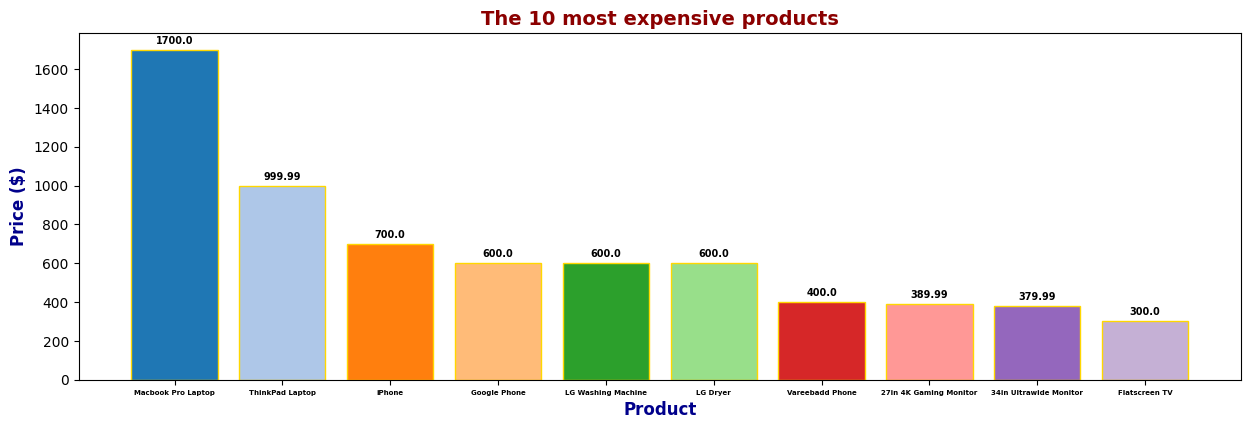

In [13]:
df_prod_price = data[['Product', 'Price_Each']].sort_values('Price_Each', ascending = False).drop_duplicates().head(10)

labels = df_prod_price['Product'].to_list()
values = df_prod_price['Price_Each'].values

cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (15,4.5))
rects = ax.bar(labels, values, color = colors, linewidth = 1., edgecolor = 'gold')
ax.set_xticklabels(labels, fontsize = 5, color = 'black', fontweight = 'bold')
ax.set_ylabel('Price ($)', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Product', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_title('The 10 most expensive products', fontsize = 14, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = f'{height}',
                xy = (rect.get_x() + rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                color = 'black',
                weight = 'bold',
                size = 7)
autolabel(rects)
fig.show()

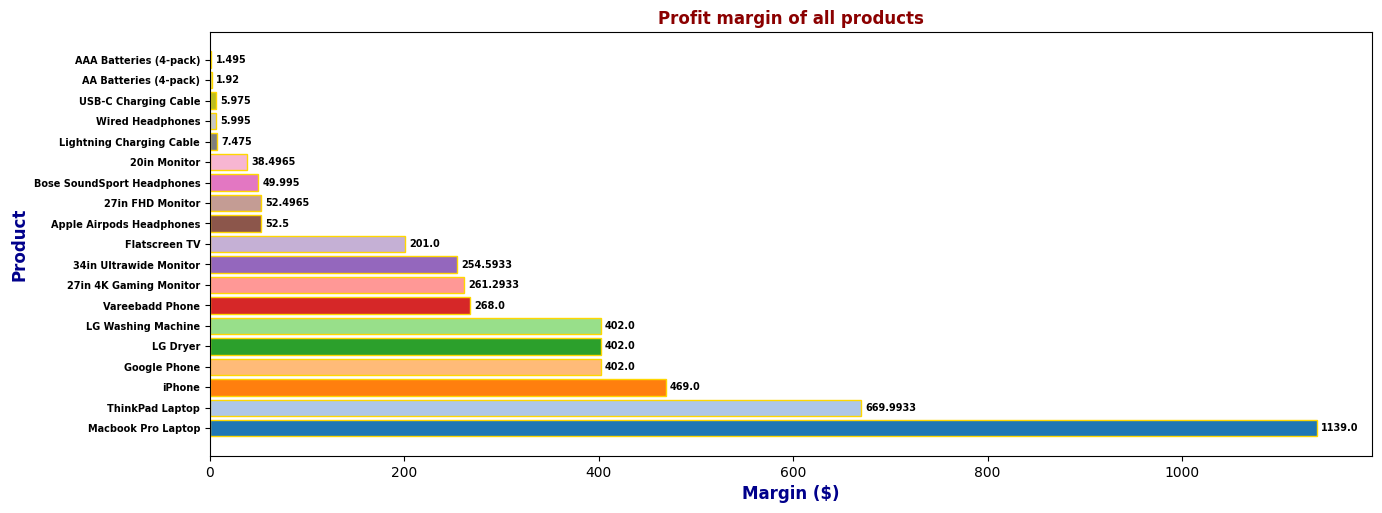

In [14]:
df_prod_margin = data[data['Quantity_Ordered']  == 1][['Product', 'margin']].sort_values('margin', ascending = False).drop_duplicates()

labels = df_prod_margin['Product']
values = df_prod_margin['margin'].values


cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (15,5.5))

rects = ax.barh(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.set_xlabel('Margin ($)', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Product', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_yticklabels(labels, fontweight = 'bold', fontsize = 7, color = 'black')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('Profit margin of all products', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    width = rect.get_width()
    ax.annotate(text = f'{width}',
                xy = (width, rect.get_y() + rect.get_height()/2),
                xytext = (3,0),
                textcoords = 'offset points',
                ha = 'left',
                va = 'center',
                weight = 'bold',
                color = 'black',
                size = 7)

autolabel(rects)

fig.show()

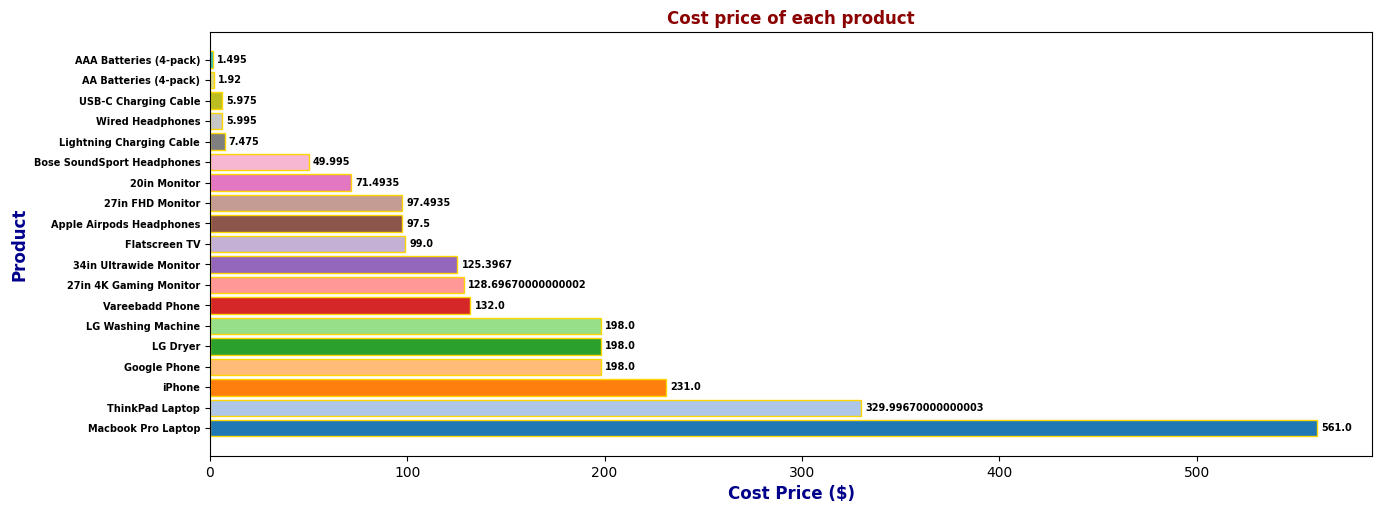

In [15]:
df_prod_cost = data[data['Quantity_Ordered']  == 1][['Product', 'Cost_price']].sort_values('Cost_price', ascending = False).drop_duplicates()

labels = df_prod_cost['Product']
values = df_prod_cost['Cost_price'].values


cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (15,5.5))

rects = ax.barh(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.set_xlabel('Cost Price ($)', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Product', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_yticklabels(labels, fontweight = 'bold', fontsize = 7, color = 'black')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('Cost price of each product', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    width = rect.get_width()
    ax.annotate(text = f'{width}',
                xy = (width, rect.get_y() + rect.get_height()/2),
                xytext = (3,0),
                textcoords = 'offset points',
                ha = 'left',
                va = 'center',
                weight = 'bold',
                color = 'black',
                size = 7)

autolabel(rects)

fig.show()

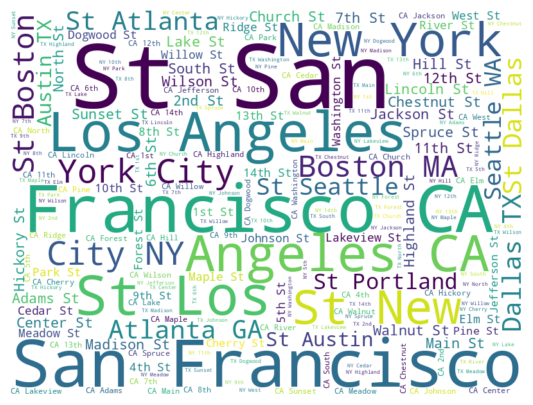

In [17]:
# WordCloud of Purchase Address
all_text = ' '.join(data['Purchase_Address'])

wordcloud = WordCloud(width = 800, height = 600, background_color = 'white').generate(all_text)

plt.figure(figsize=(9, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.grid(False)
plt.axis('off')
plt.show()

In [18]:
df_total_sales = data[['Product', 'Quantity_Ordered', 'Price_Each']]
df_total_sales['total_sales'] = df_total_sales['Price_Each']*df_total_sales['Quantity_Ordered']
df_total_sales.head()

,Product,Quantity_Ordered,Price_Each,total_sales
0,iPhone,1,700.00,700.00
1,Lightning Charging Cable,1,14.95,14.95
2,Wired Headphones,2,11.99,23.98
3,27in FHD Monitor,1,149.99,149.99
4,Wired Headphones,1,11.99,11.99


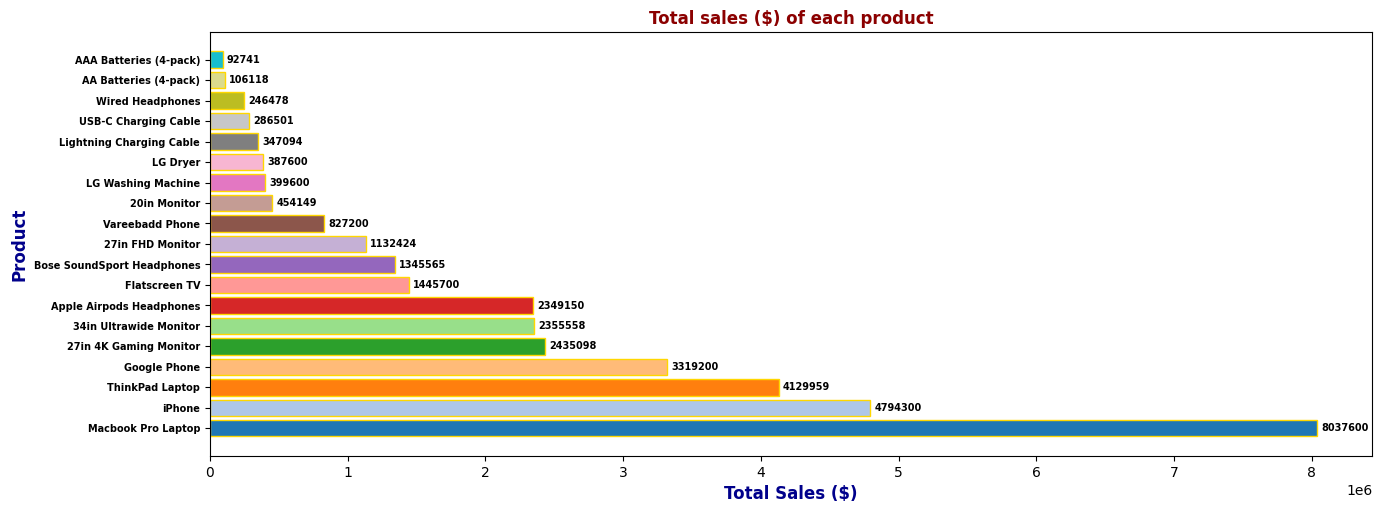

In [19]:
df_total_sales_prod = df_total_sales.groupby('Product')['total_sales'].sum().to_frame().sort_values('total_sales', ascending = False)
labels = df_total_sales_prod.index.to_list()
values = df_total_sales_prod['total_sales'].values


cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (15,5.5))

rects = ax.barh(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.set_xlabel('Total Sales ($)', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_ylabel('Product', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_yticklabels(labels, fontweight = 'bold', fontsize = 7, color = 'black')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('Total sales ($) of each product', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    width = rect.get_width()
    ax.annotate(text = f'{round(width)}',
                xy = (width, rect.get_y() + rect.get_height()/2),
                xytext = (3,0),
                textcoords = 'offset points',
                ha = 'left',
                va = 'center',
                weight = 'bold',
                color = 'black',
                size = 7)

autolabel(rects)

fig.show()

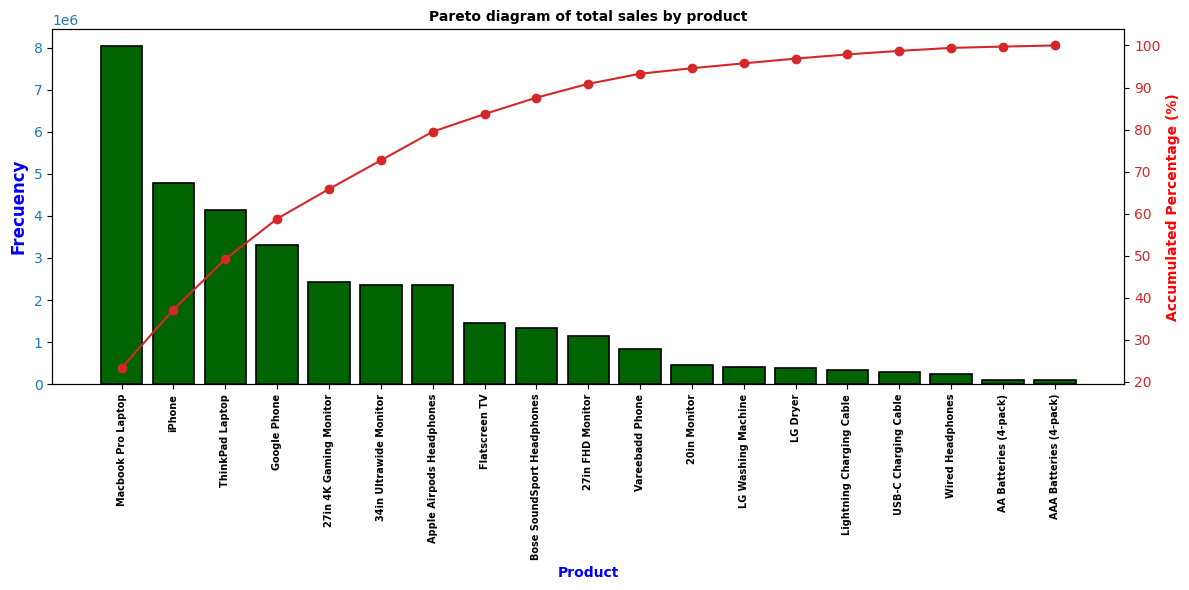

In [20]:
df_total_sales_prod = df_total_sales.groupby('Product')['total_sales'].sum().to_frame().sort_values('total_sales', ascending = False)
df_total_sales_prod['total_sales_cum']= df_total_sales_prod.cumsum()
df_total_sales_prod['%_total_sales'] = (df_total_sales_prod['total_sales']/sum(df_total_sales_prod['total_sales']))*100
df_total_sales_prod['%_total_sales_cum'] = df_total_sales_prod['%_total_sales'].cumsum()

categories = df_total_sales_prod.index.to_list()
values = df_total_sales_prod.iloc[:,0].to_list()
cumulative_percentages = df_total_sales_prod.iloc[:,3].to_list()

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(categories, values, color='darkgreen', linewidth = 1.2, edgecolor = 'black')
ax1.set_xlabel('Product', color = 'blue', fontsize = 10, fontweight = 'bold')
ax1.set_ylabel('Frecuency', color='blue', fontsize = 12, fontweight = 'bold')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticklabels(categories, weight = 'bold')
ax1.tick_params(axis = 'x', rotation = 90, labelsize = 7)


ax2 = ax1.twinx()
ax2.plot(categories, cumulative_percentages, color='tab:red', marker='o')
ax2.set_ylabel('Accumulated Percentage (%)', color='red', fontsize = 10, fontweight = 'bold')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_title('Pareto diagram of total sales by product', fontsize = 10, fontweight = 'bold', color = 'black')
fig.tight_layout()
fig.show()

In [21]:
# Set the 'Order Date' column to datetime64 format
data['Order_Date'] = pd.to_datetime(data['Order_Date'])

In [22]:
# We generate a copy of our data so as not to generate any columns.
data_new = data.copy()

In [23]:
# Create a column called 'Hour'.
data_new['Hour'] = data_new['Order_Date'].dt.hour # we extract the time

In [24]:
# Create a column called 'Day'
data_new['Day'] = data_new['Order_Date'].dt.day_name() # We extract the day of the week.

In [25]:
# Create a column called 'Month'
data_new['Month'] = data_new['Order_Date'].dt.month_name() # we extract the month

In [26]:
# Create a column called 'Year'
data_new['Year'] = data_new['Order_Date'].dt.year # extraemos el año.

In [27]:
# We display the new dataframe.
data_new.head()

,Order_Date,Order_ID,Product,Product_ean,catégorie,Purchase_Address,Quantity_Ordered,Price_Each,Cost_price,turnover,margin,Hour,Day,Month,Year
0,2019-01-22 21:25:00,141234,iPhone,5.638009e+12,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,21,Tuesday,January,2019
1,2019-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,14,Monday,January,2019
2,2019-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,13,Thursday,January,2019
3,2019-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,20,Saturday,January,2019
4,2019-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,11,Friday,January,2019


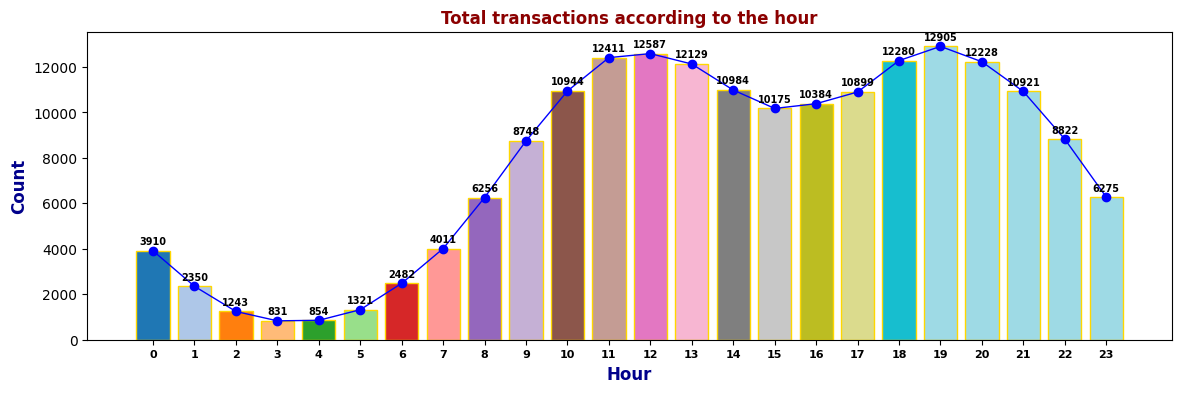

In [28]:
df_popu_hour = data_new['Hour'].value_counts().to_frame().sort_index()
df_popu_hour.index = df_popu_hour.index.astype('str')

labels = df_popu_hour.index.to_list()
values = df_popu_hour.iloc[:,0].values

cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (14,4))
rects = ax.bar(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.plot(labels, values, '-o', linewidth = 1., color = 'blue')
ax.set_ylabel('Count', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Hour', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xticklabels(labels, fontsize = 8, fontweight = 'bold')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('Total transactions according to the hour', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = '{}'.format(height),
                xy = (rect.get_x() + rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                weight = 'bold',
                size = 7,
                color = 'black')

autolabel(rects)
fig.show()

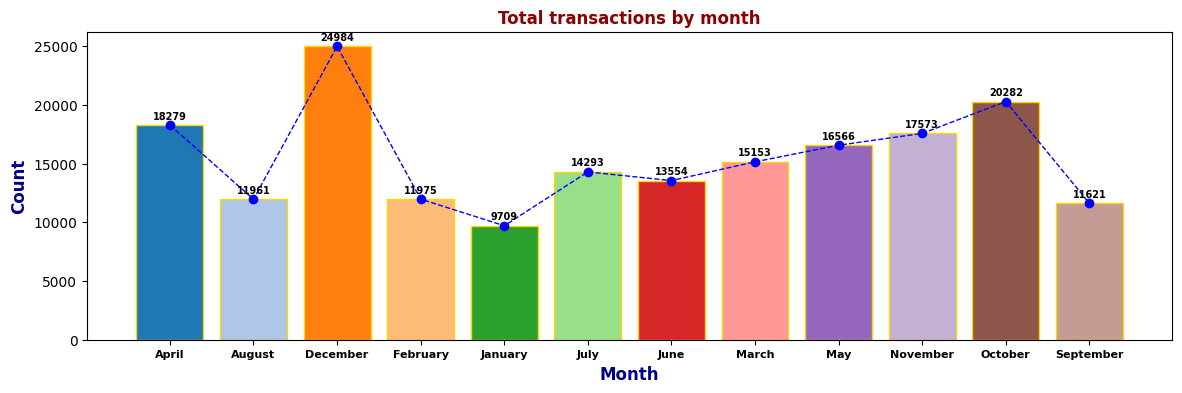

In [29]:
df_popu_month = data_new['Month'].value_counts().to_frame().sort_index()
df_popu_month.index = df_popu_month.index.astype('str')

labels = df_popu_month.index.to_list()
values = df_popu_month.iloc[:,0].values

cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (14,4))
rects = ax.bar(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.plot(labels, values, '--o', linewidth = 1., color = 'blue')
ax.set_ylabel('Count', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Month', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xticklabels(labels, fontsize = 8, fontweight = 'bold')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('Total transactions by month', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = '{}'.format(height),
                xy = (rect.get_x() + rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                weight = 'bold',
                size = 7,
                color = 'black')

autolabel(rects)
fig.show()

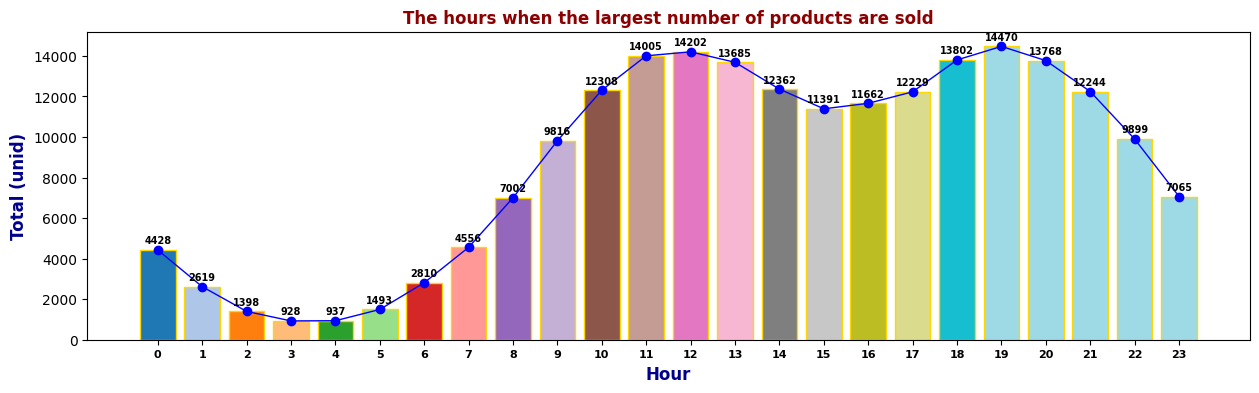

In [30]:
df_hour_quantity = data_new.groupby('Hour')['Quantity_Ordered'].sum().to_frame()
df_hour_quantity.index = df_hour_quantity.index.astype('str')

labels = df_hour_quantity.index.to_list()
values = df_hour_quantity.iloc[:,0].values

cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (15,4))
rects = ax.bar(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.plot(labels, values, '-o', linewidth = 1., color = 'blue')
ax.set_ylabel('Total (unid)', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Hour', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xticklabels(labels, fontsize = 8, fontweight = 'bold')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('The hours when the largest number of products are sold', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = '{}'.format(height),
                xy = (rect.get_x() + rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                weight = 'bold',
                size = 7,
                color = 'black')

autolabel(rects)
fig.show()

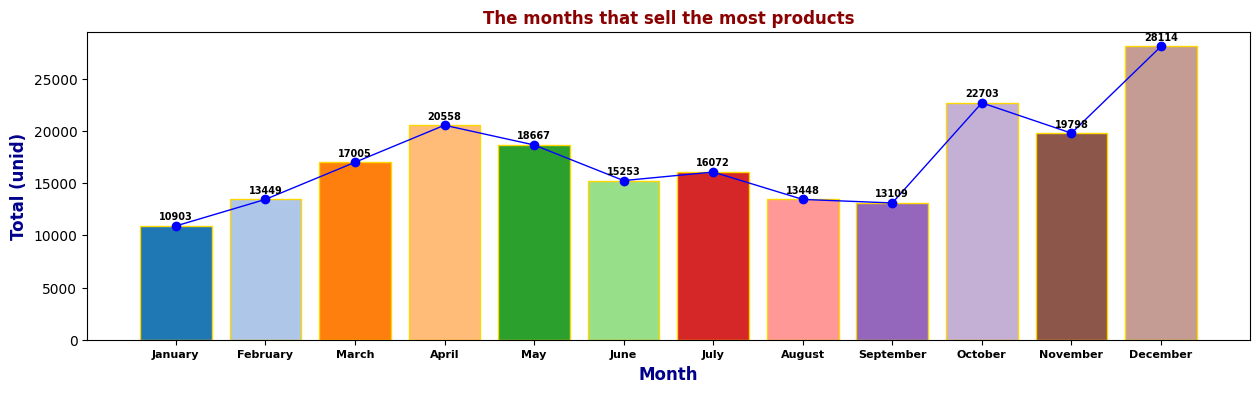

In [31]:
# We define the months to be able to order them according to these months.
custom_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

df_month_quantity = data_new.groupby('Month')['Quantity_Ordered'].sum().to_frame().reset_index()

df_month_quantity['Month'] = df_month_quantity['Month'].astype(pd.CategoricalDtype(categories=custom_order, ordered=True))
df_month_quantity = df_month_quantity.sort_values('Month', ascending = True)

labels = df_month_quantity.iloc[:,0].to_list()
values = df_month_quantity.iloc[:,1].values

cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (15,4))
rects = ax.bar(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.plot(labels, values, '-o', linewidth = 1., color = 'blue')
ax.set_ylabel('Total (unid)', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Month', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xticklabels(labels, fontsize = 8, fontweight = 'bold')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('The months that sell the most products', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = '{}'.format(height),
                xy = (rect.get_x() + rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                weight = 'bold',
                size = 7,
                color = 'black')

autolabel(rects)
fig.show()

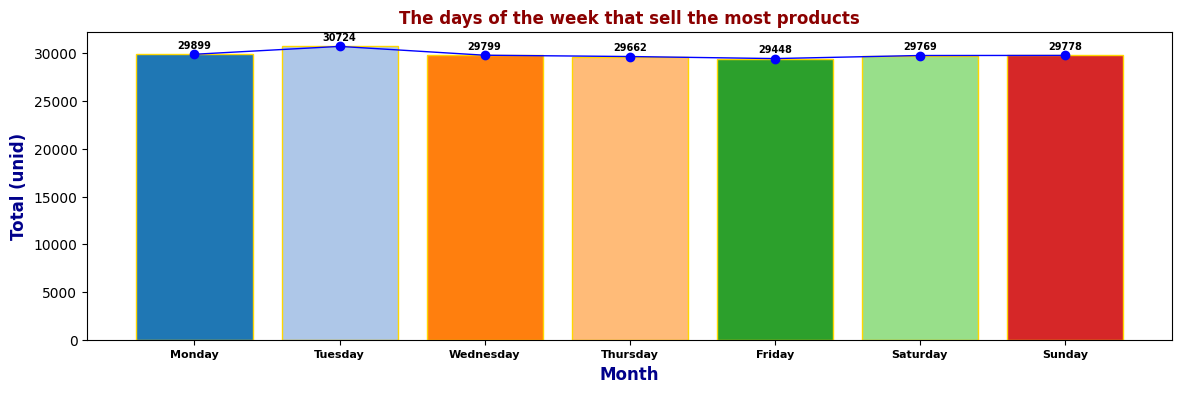

In [32]:
# We define the days of the week to be able to order them according to these days.
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_day_quantity = data_new.groupby('Day')['Quantity_Ordered'].sum().to_frame().reset_index()

df_day_quantity['Day'] = df_day_quantity['Day'].astype(pd.CategoricalDtype(categories=custom_order, ordered=True))
df_day_quantity = df_day_quantity.sort_values('Day', ascending = True)

labels = df_day_quantity.iloc[:,0].to_list()
values = df_day_quantity.iloc[:,1].values

cmap = plt.get_cmap('tab20')
colors = cmap(np.arange(len(labels)))

fig,ax = plt.subplots(figsize = (14,4))
rects = ax.bar(labels, values, linewidth = 1. , edgecolor = 'gold', color = colors)
ax.plot(labels, values, '-o', linewidth = 1., color = 'blue')
ax.set_ylabel('Total (unid)', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Month', fontsize = 12, fontweight = 'bold', color = 'darkblue')
ax.set_xticklabels(labels, fontsize = 8, fontweight = 'bold')
ax.tick_params('x', labelcolor = 'black')
ax.set_title('The days of the week that sell the most products', fontsize = 12, fontweight = 'bold', color = 'darkred')

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(text = '{}'.format(height),
                xy = (rect.get_x() + rect.get_width()/2, height),
                xytext = (0,3),
                textcoords = 'offset points',
                ha = 'center',
                va = 'bottom',
                weight = 'bold',
                size = 7,
                color = 'black')

autolabel(rects)
fig.show()

In [33]:
# We order our data according to the date of purchase.
data_new_ordered = data_new.sort_values('Order_Date', ascending = True)

data_new_ordered = data_new_ordered.set_index('Order_Date')
data_new_ordered.head()

,Order_ID,Product,Product_ean,catégorie,Purchase_Address,Quantity_Ordered,Price_Each,Cost_price,turnover,margin,Hour,Day,Month,Year
Order_Date,,,,,,,,,,,,,,
2019-01-01 03:07:00,147268,Wired Headphones,4.648137e+12,Sports,"9 Lake St, New York City, NY 10001",1,11.99,5.995,11.99,5.995,3,Tuesday,January,2019
2019-01-01 03:40:00,148041,USB-C Charging Cable,9.042705e+12,Vêtements,"760 Church St, San Francisco, CA 94016",1,11.95,5.975,11.95,5.975,3,Tuesday,January,2019
2019-01-01 04:56:00,149343,Apple Airpods Headphones,7.725490e+12,Sports,"735 5th St, New York City, NY 10001",1,150.00,97.500,150.00,52.500,4,Tuesday,January,2019
2019-01-01 05:53:00,149964,AAA Batteries (4-pack),6.453768e+12,Vêtements,"75 Jackson St, Dallas, TX 75001",1,2.99,1.495,2.99,1.495,5,Tuesday,January,2019
2019-01-01 06:03:00,149350,USB-C Charging Cable,1.826840e+12,Sports,"943 2nd St, Atlanta, GA 30301",2,11.95,5.975,23.90,11.950,6,Tuesday,January,2019


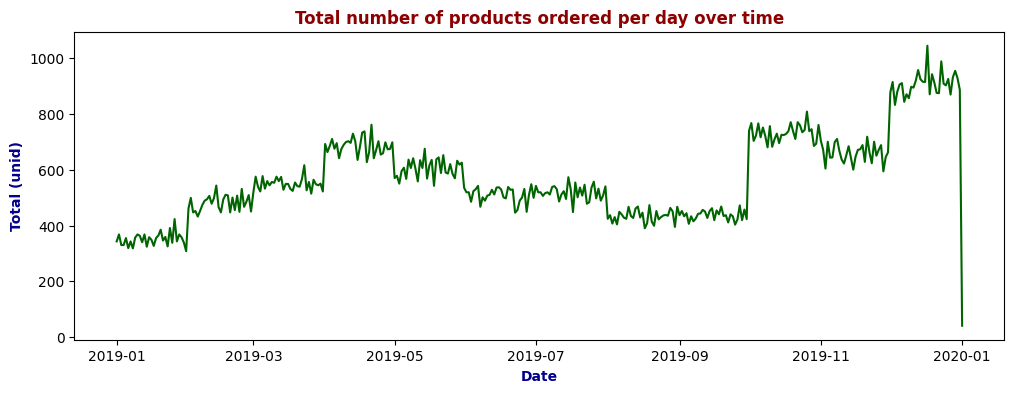

In [34]:
# We generated a resample to group them by day.
df_day_resample = data_new_ordered.Quantity_Ordered.resample('D').sum().to_frame()

fig, ax = plt.subplots(figsize = (12,4))
ax.plot(df_day_resample.index, df_day_resample.iloc[:,0], color = 'darkgreen')
ax.set_ylabel('Total (unid)', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Date', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_title('Total number of products ordered per day over time', fontsize = 12, fontweight = 'bold', color = 'darkred')
fig.show()

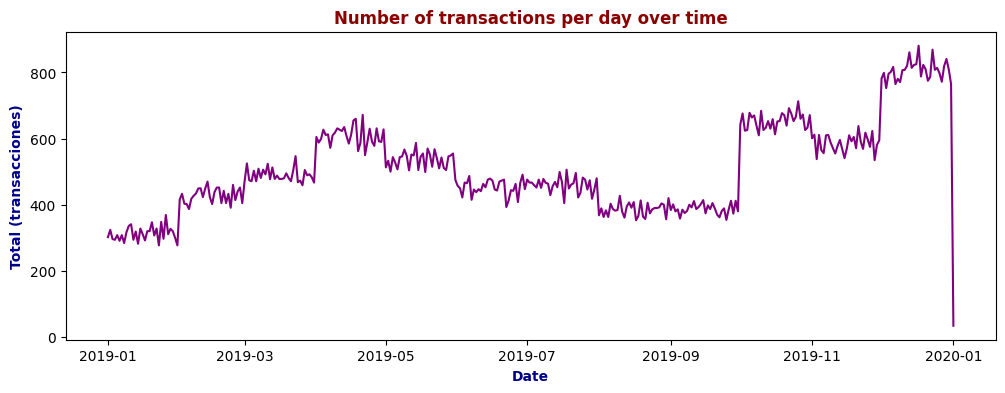

In [35]:
# We generated a resample to group them by day.
df_day_transac_resample = data_new_ordered.resample('D').size().to_frame()

fig, ax = plt.subplots(figsize = (12,4))
ax.plot(df_day_transac_resample.index, df_day_transac_resample.iloc[:,0], color = 'purple')
ax.set_ylabel('Total (transacciones)', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Date', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_title('Number of transactions per day over time', fontsize = 12, fontweight = 'bold', color = 'darkred')
fig.show()

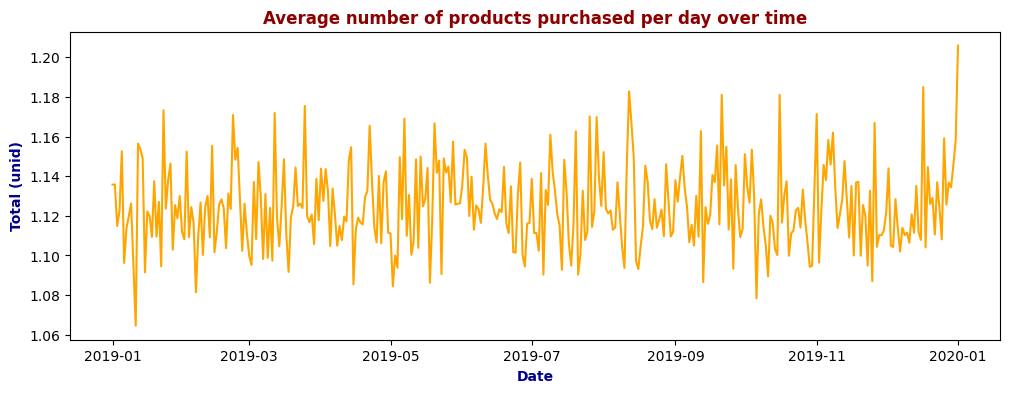

In [36]:
# We generated a resample to group them by day.
df_day_resample_mean = data_new_ordered.Quantity_Ordered.resample('D').mean().to_frame()

fig, ax = plt.subplots(figsize = (12,4))
ax.plot(df_day_resample_mean.index, df_day_resample_mean.iloc[:,0], color = 'orange')
ax.set_ylabel('Total (unid)', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_xlabel('Date', fontsize = 10, fontweight = 'bold', color = 'darkblue')
ax.set_title('Average number of products purchased per day over time', fontsize = 12, fontweight = 'bold', color = 'darkred')
fig.show()

**Insights**


*   Sales fluctuate based on month. Low sales months can be targeted for promotions and marketing
*   Sales fluctuate based on hour of the day. Promotions could be aimed at specific hours to support sales.


